# Imports

In [65]:
import pickle
import re
import string
import unicodedata
from collections import Counter
from typing import Any, Union, Optional, Callable

import joblib
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, BatchNormalization, Dropout
from keras.losses import binary_crossentropy
from keras.optimizers.adamw import AdamW
from keras.utils import plot_model
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer, word_tokenize
from nltk.corpus import wordnet, stopwords
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import compute_class_weight
from tensorflow.python.keras.metrics import Precision, Recall, AUC

# Functions

In [ ]:
def map_targets(watson_list, fix_targets):
    targets = set(fix_targets.keys()) & set(watson_list)
    mapped_targets = {fix_targets[category] for category in targets}
    return list(mapped_targets) if mapped_targets else ['other']


def clean_text(text, remove_punctuation=True, remove_emojis=True, normalize_whitespace=True, lowercase=True):
    """
    Clean and preprocess text data for machine learning tasks.

    Args:
        text (str): Input text to be cleaned.
        remove_punctuation (bool): Whether to remove punctuation. Default is True.
        remove_emojis (bool): Whether to remove emojis and emoticons. Default is True.
        normalize_whitespace (bool): Whether to normalize whitespace. Default is True.
        lowercase (bool): Whether to convert text to lowercase. Default is True.

    Returns:
        str: Cleaned and preprocessed text.
    """
    # Convert text to lowercase if specified
    if lowercase:
        text = text.lower()

    # Remove punctuation if specified
    if remove_punctuation:
        text = re.sub(r'[^\w\s]', '', text)

    # Normalize whitespace if specified
    if normalize_whitespace:
        text = re.sub(r'\s+', ' ', text).strip()

    # Remove emojis and emoticons if specified
    if remove_emojis:
        # Remove emojis and emoticons using Unicode ranges
        text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
        # Remove additional emoticons and symbols
        text = re.sub(r'[\u2600-\u26FF\u2700-\u27BF]', '', text)

    # Normalize Unicode characters (e.g., convert accented characters to their base form)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    return text


def lemmatize_text(text, lemmatizer=WordNetLemmatizer()):
    """
    Lemmatize text using WordNetLemmatizer with POS tagging for better accuracy.

    Args:
        text (str): Input text to be lemmatized.
        lemmatizer (WordNetLemmatizer): Lemmatizer instance. Default is WordNetLemmatizer().

    Returns:
        str: Lemmatized text.
    """
    # Tokenize the text
    tokens = word_tokenize(text)

    # Get POS tags for each token
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize each token with its corresponding POS tag
    lemmatized_tokens = []
    for token, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag)  # Convert Treebank tag to WordNet POS
        lemmatized_token = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmatized_tokens.append(lemmatized_token)

    # Join the lemmatized tokens into a single string
    return ' '.join(lemmatized_tokens)


def get_wordnet_pos(treebank_tag):
    """
    Map Treebank POS tags to WordNet POS tags for lemmatization.

    Args:
        treebank_tag (str): Treebank POS tag.

    Returns:
        str: Corresponding WordNet POS tag.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match


def remove_stopwords(text, language='english', custom_stopwords=None, lowercase=True):
    """
    Remove stopwords from the input text.

    Args:
        text (str): Input text to process.
        language (str): Language of the stopwords. Default is 'english'.
        custom_stopwords (set): Custom set of stopwords to use. Default is None.
        lowercase (bool): Whether to convert text to lowercase before processing. Default is True.

    Returns:
        str: Text with stopwords removed.
    """
    # Convert text to lowercase if specified
    if lowercase:
        text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Load stopwords
    if custom_stopwords is not None:
        stop_words = set(custom_stopwords)
    else:
        stop_words = set(stopwords.words(language))

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Join the filtered tokens into a single string
    return ' '.join(filtered_tokens)


def replace_text_components(text, replace_emails=True, replace_urls=True, replace_mentions=True, replace_hashtags=True,
                            replace_phone_numbers=True, custom_replacements=None):
    """
    Replace specific text components (e.g., emails, URLs, mentions, hashtags) with placeholders.

    Args:
        text (str): Input text to process.
        replace_emails (bool): Whether to replace email addresses. Default is True.
        replace_urls (bool): Whether to replace URLs. Default is True.
        replace_mentions (bool): Whether to replace mentioned users. Default is True.
        replace_hashtags (bool): Whether to replace hashtags. Default is True.
        replace_phone_numbers (bool): Whether to replace phone numbers. Default is True.
        custom_replacements (dict): Custom replacement rules as a dictionary. Default is None.

    Returns:
        str: Text with specified components replaced.
    """
    # Replace email addresses
    if replace_emails:
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    # Replace URLs
    if replace_urls:
        text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Replace mentioned users
    if replace_mentions:
        text = re.sub(r'@\w+', '', text)

    # Replace hashtags
    if replace_hashtags:
        text = re.sub(r'#\w+', '', text)  # Remove hashtags entirely

    # Replace phone numbers
    if replace_phone_numbers:
        text = re.sub(r'\b(?:\+\d{1,2}\s?)?(?:\(\d{3}\)|\d{3})[\s.-]?\d{3}[\s.-]?\d{4}\b', '', text)

    # Apply custom replacements if provided
    if custom_replacements is not None:
        for pattern, replacement in custom_replacements.items():
            text = re.sub(pattern, replacement, text)

    return text


def tokenizer_transform(
        x: pd.Series,
        embedder_addr: str,
        preprocessing_list: Optional[list[Callable[[str], str]]] = None,
) -> np.ndarray[Any, np.dtype[Any]]:
    """
    Generate embeddings for the sentences in the DataFrame.

    Args:
        x (pd.Series): The DataFrame containing the sentences.
        embedder_addr (str): Address of the embedder.
        preprocessing_list (list[callable]): List of functions to apply to each sentence.
    """
    # Preprocess the text
    sentences = x.tolist()

    if preprocessing_list is None:
        preprocessing_list = []

    for preprocessor in preprocessing_list:
        sentences = [preprocessor(s) for s in sentences]

    model = SentenceTransformer(model_name_or_path=embedder_addr)
    return model.encode(sentences)

In [60]:
def build_network(X_train, y_train):
    num_labels = y_train.shape[1]
    class_weight_dict = {}

    for i in range(num_labels):
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train[:, i]),
            y=y_train[:, i]
        )
        class_weight_dict[i] = class_weights[1]  # Assign weight for positive class

    def custom_weighted_loss(y_true, y_pred):
        loss = 0
        for i in range(num_labels):
            loss += class_weight_dict[i] * binary_crossentropy(y_true[:, i], y_pred[:, i])
        return loss / num_labels

    input_text = tf.keras.Input(shape=X_train.shape[1])
    x = Dense(1024, activation='relu')(input_text)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(y_train.shape[1], activation='sigmoid')(x)
    sequential = tf.keras.Model(inputs=input_text, outputs=output)
    sequential.compile(
        loss=custom_weighted_loss,
        optimizer=AdamW(),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='f1_score')]
    )
    sequential.summary()
    return sequential


def evaluate(X_val, y_val, model, classes):
    y_pred = model.predict(x=X_val)
    y_pred_binary = np.asarray(a=y_pred > THRESHOLD, dtype=np.int32)

    # Evaluation using Multi-label metrics
    subset_accuracy = accuracy_score(y_true=y_val, y_pred=y_pred_binary, normalize=True)
    hamming = hamming_loss(y_true=y_val, y_pred=y_pred_binary)
    roc_auc = roc_auc_score(y_true=y_val, y_score=y_pred_binary)

    print(classification_report(
        y_true=y_val,
        y_pred=y_pred_binary,
        target_names=classes,
        zero_division=0.0
    ))
    print(f"Subset Accuracy: {subset_accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"AUC Score: {roc_auc:.4f}")


def preprocess_data(X, y):
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        #stratify=y,
        shuffle=True
    )

    embedder = SentenceTransformer('basel/ATTACK-BERT')
    X_train = embedder.encode(list(X_train))
    X_val = embedder.encode(list(X_val))

    # Binarizing labels (Multi-label transformation)
    mlb = MultiLabelBinarizer()
    y_train = mlb.fit_transform(y_train)
    y_val = mlb.transform(y_val)
    return X_train, X_val, y_train, y_val, mlb.classes_


def plot_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i + 1)
        plt.plot(history[metric], label=f"Train {metric}")
        plt.plot(history[f"val_{metric}"], label=f"Val {metric}")
        plt.xlabel(xlabel="Epochs")
        plt.ylabel(ylabel=metric.capitalize())
        plt.legend()
        plt.title(label=f"{metric.capitalize()} Over Epochs")

    plt.tight_layout()
    plt.show()

In [67]:
BATCH_SIZE = 8
EPOCHS = 2
RANDOM_STATE = 42
TEST_SIZE = 0.3
THRESHOLD = 0.4

# Load Dataset

In [52]:
with open('data/tweets-dataset/training_tweets_for_category_clf.pkl', 'rb') as f:
    train_tweets = pd.DataFrame(data=pickle.load(file=f), columns=[
        '_id', 'date',
        'id', 'relevant', 'text', 'tweet', 'type', 'watson',
        'annotation', 'urls', 'destination_url',
        'valid_certificate', 'watson_list', 'target'
    ])

train_tweets['text'] = [replace_text_components(t) for t in train_tweets['text']]
train_tweets['text'] = [clean_text(t) for t in train_tweets['text']]
train_tweets['text'] = [lemmatize_text(t) for t in train_tweets['text']]
train_tweets['text'] = [remove_stopwords(t) for t in train_tweets['text']]

Target Frequencies:
computer security: 7729
antivirus and malware: 4904
software: 4452
network security: 3591
hardware: 2882
computer: 2007
other: 1804
databases: 1620
operating systems: 1462
networking: 1226
linux: 610
computer networking: 430
router: 376
windows: 372
computer components: 353
unix: 274
mac os: 212
servers: 159
portable computer: 130
wireless technology: 68
desktop computer: 16


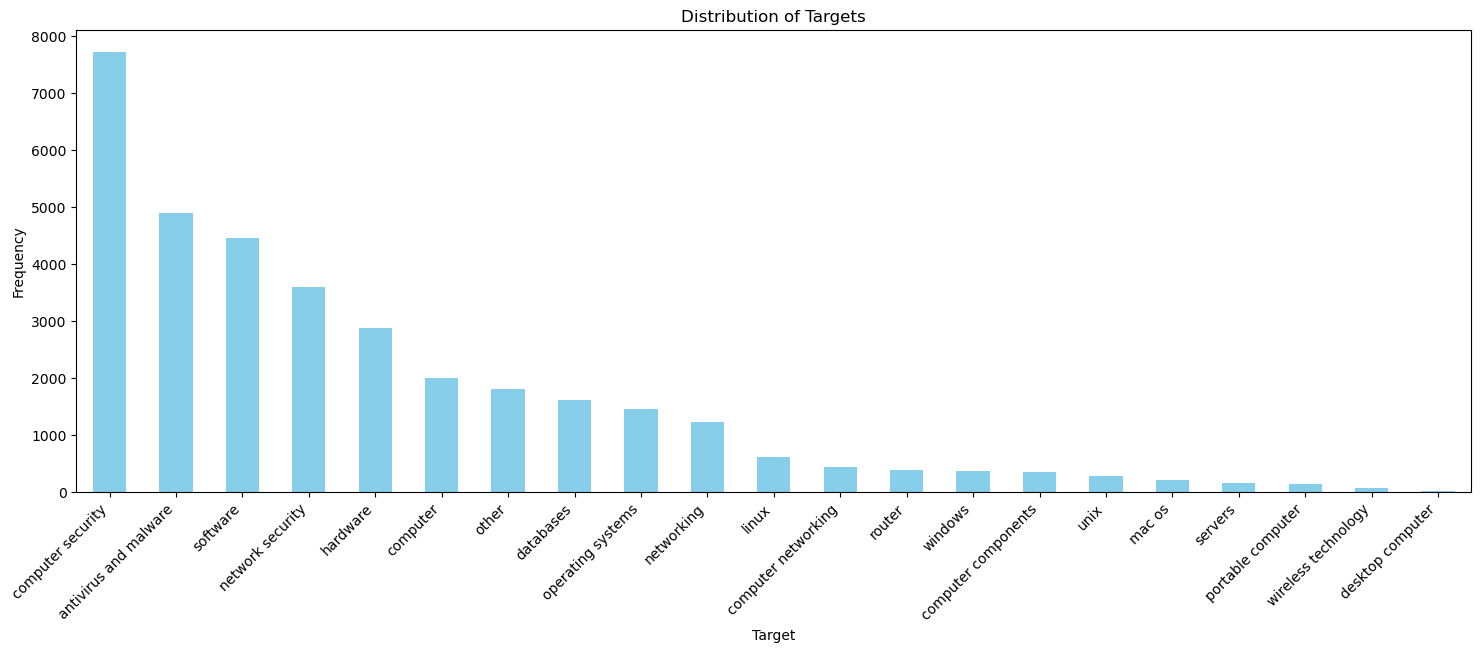

In [53]:
class_freq = Counter([item for sublist in train_tweets['target'] for item in sublist])
print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [57]:
X_train_tot, X_val_tot, y_train_tot, y_val_tot, classes_tot = preprocess_data(
    train_tweets['text'],
    train_tweets['target']
)
classes_tot

array(['antivirus and malware', 'computer', 'computer components',
       'computer networking', 'computer security', 'databases',
       'desktop computer', 'hardware', 'linux', 'mac os',
       'network security', 'networking', 'operating systems', 'other',
       'portable computer', 'router', 'servers', 'software', 'unix',
       'windows', 'wireless technology'], dtype=object)

In [76]:
output_order = [
    'computer security', 'hardware', 'networking', 'operating systems', 'other', 'software',
    'antivirus and malware', 'network security', 'computer', 'computer components',
    'computer networking', 'desktop computer', 'portable computer', 'servers', 'router',
    'wireless technology', 'linux', 'mac os', 'unix', 'windows', 'databases'
]

# Create a dictionary to map model output index to target index
output_index = {name: idx for idx, name in enumerate(output_order)}
reordered_indices = [output_index[name] for name in classes_tot]
y_train_tot = y_train_tot[:, reordered_indices]

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 dense_271 (Dense)              (None, 512)          393728      ['input_20[0][0]']               
                                                                                                  
 dropout_178 (Dropout)          (None, 512)          0           ['dense_271[0][0]']              
                                                                                                  
 batch_normalization_178 (Batch  (None, 512)         2048        ['dropout_178[0][0]']            
 Normalization)                                                                            

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


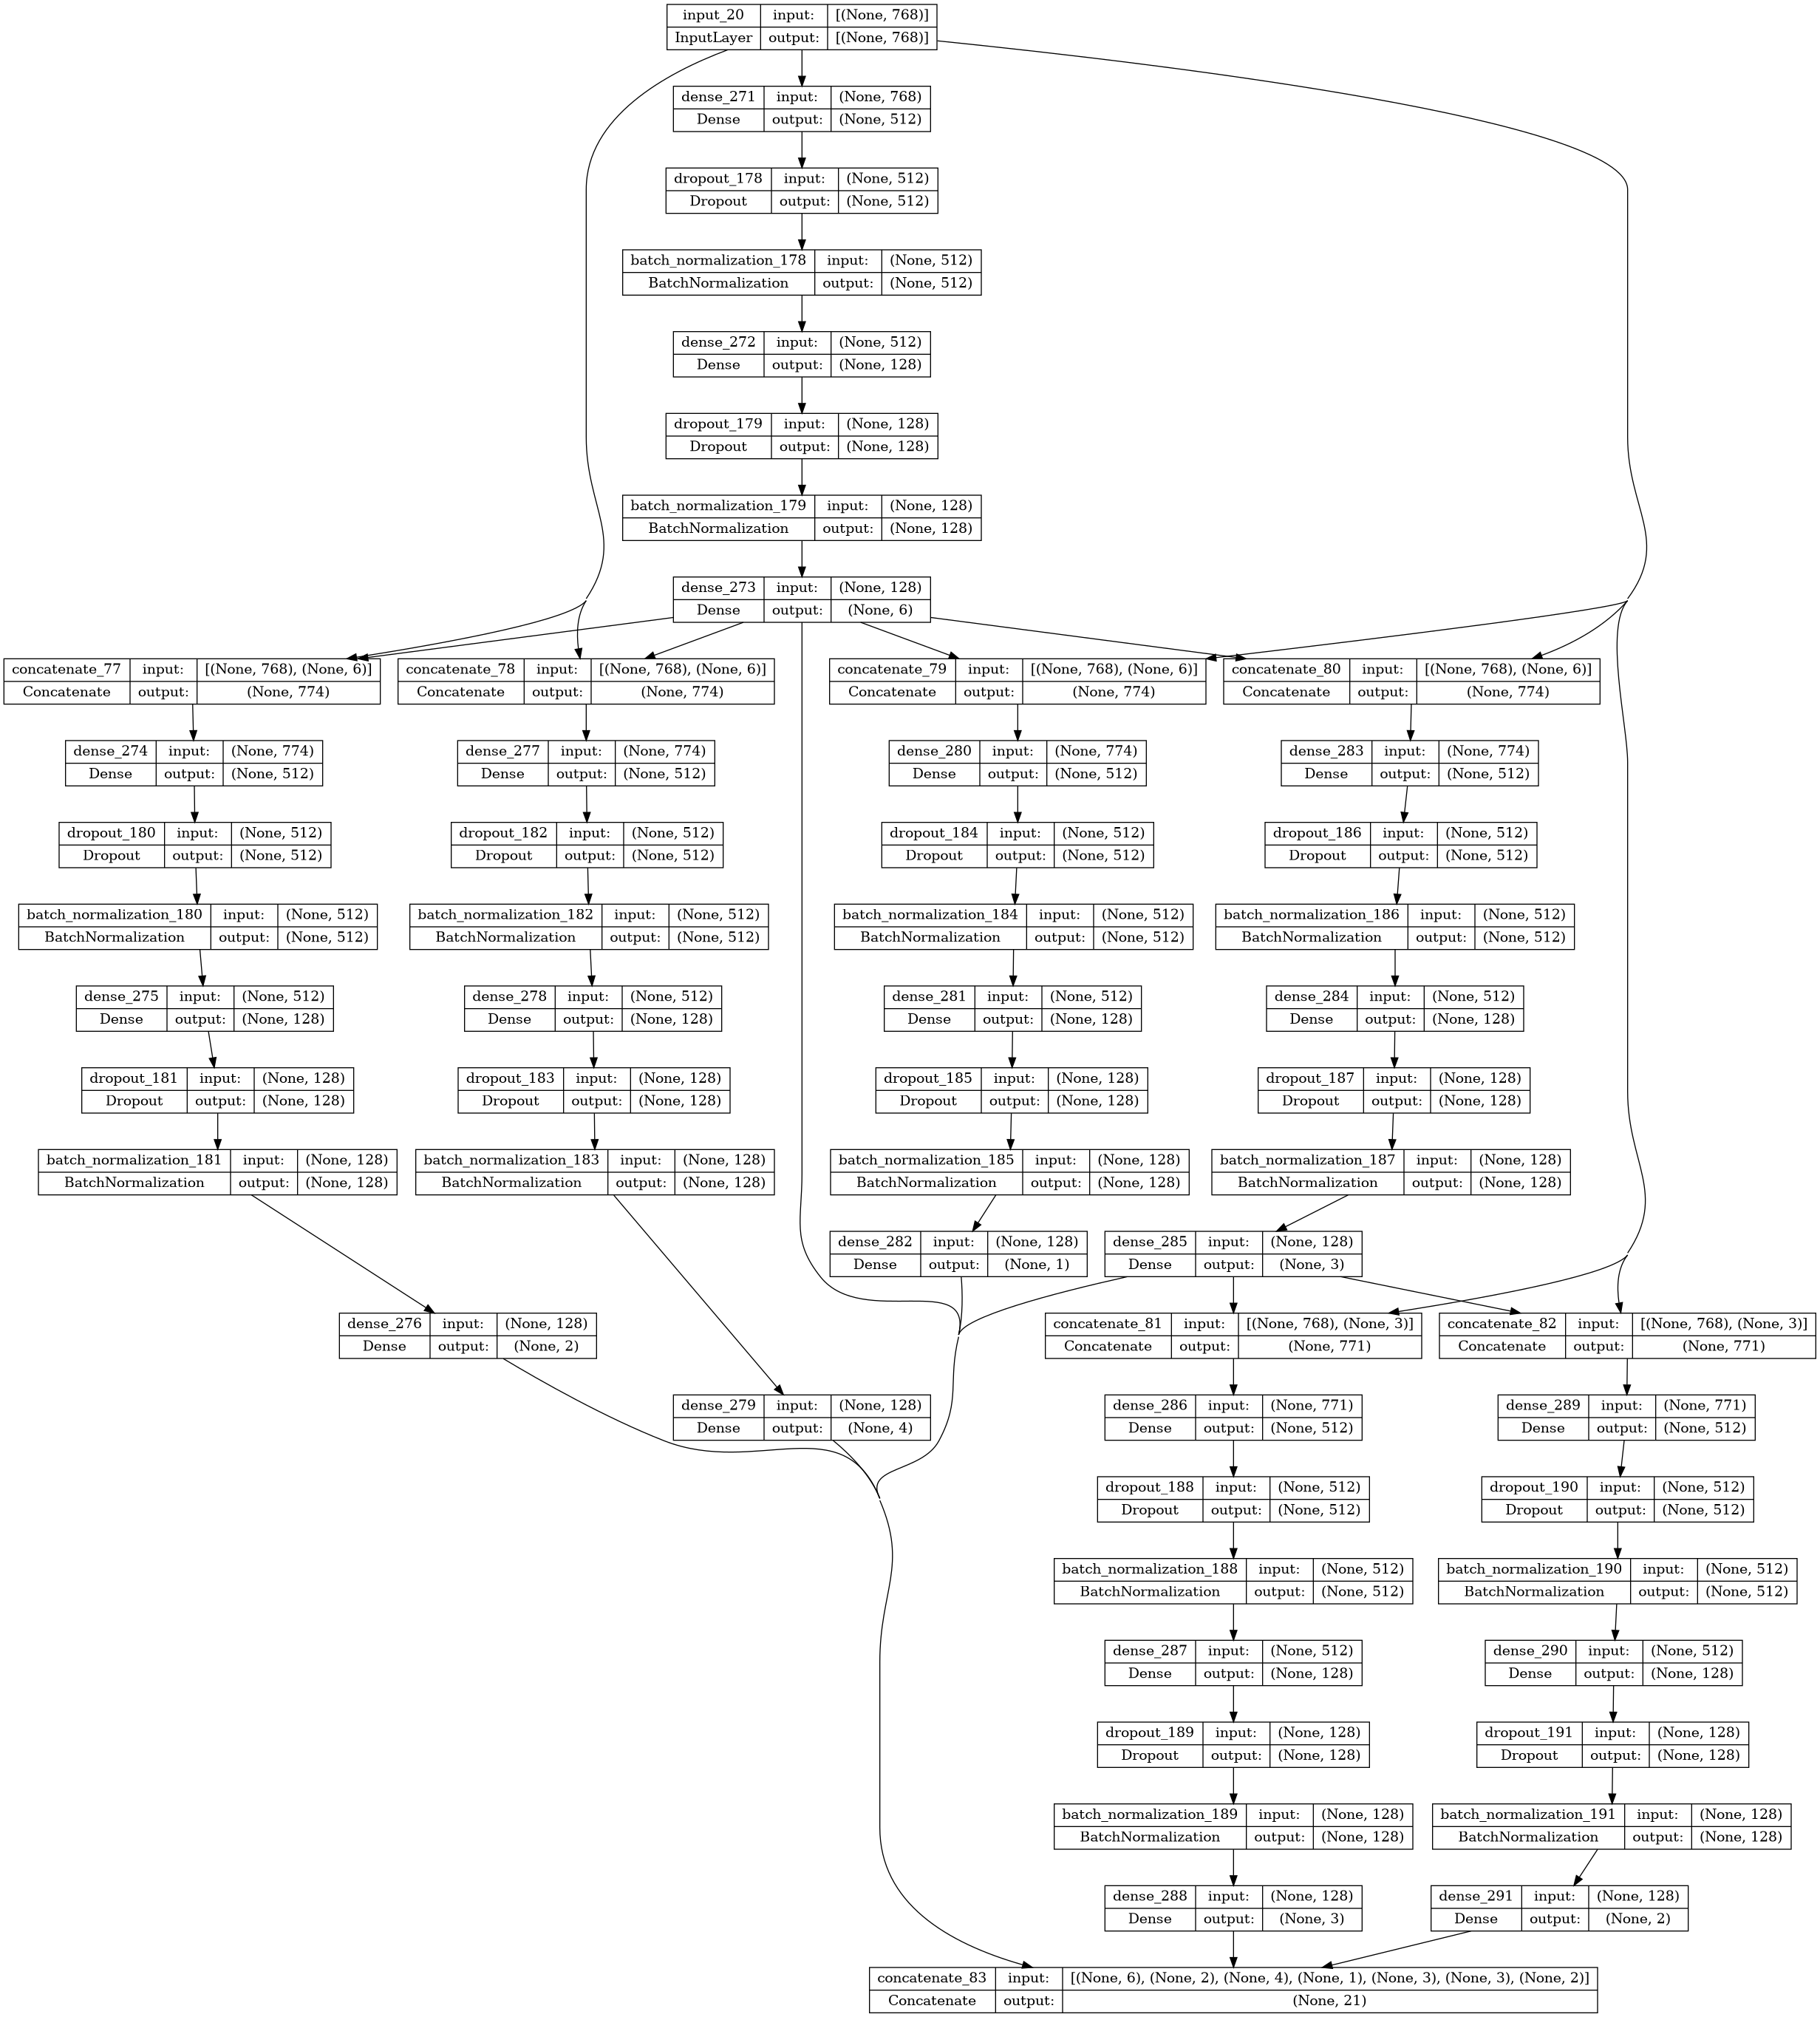

In [85]:
num_labels = y_train_tot.shape[1]
class_weight_dict = {}

for i in range(num_labels):
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train_tot[:, i]),
        y=y_train_tot[:, i]
    )
    class_weight_dict[i] = class_weights[1]  # Assign weight for positive class


def custom_weighted_loss(y_true, y_pred):
    loss = 0
    for i in range(num_labels):
        loss += class_weight_dict[i] * binary_crossentropy(y_true[:, i], y_pred[:, i])
    return loss / num_labels


input_text = tf.keras.Input(shape=X_train_tot.shape[1])

# General
general_way = Dense(512, activation='relu')(input_text)
general_way = Dropout(0.25)(general_way)
general_way = BatchNormalization()(general_way)
general_way = Dense(128, activation='relu')(general_way)
general_way = Dropout(0.25)(general_way)
general_way = BatchNormalization()(general_way)
general_output = Dense(6, activation='sigmoid')(general_way)

# Computer Security
cs_input = tf.keras.layers.concatenate([input_text, general_output])
cs_way = Dense(512, activation='relu')(cs_input)
cs_way = Dropout(0.25)(cs_way)
cs_way = BatchNormalization()(cs_way)
cs_way = Dense(128, activation='relu')(cs_way)
cs_way = Dropout(0.25)(cs_way)
cs_way = BatchNormalization()(cs_way)
cs_output = Dense(2, activation='sigmoid')(cs_way)

# Operating Systems
os_input = tf.keras.layers.concatenate([input_text, general_output])
os_way = Dense(512, activation='relu')(os_input)
os_way = Dropout(0.25)(os_way)
os_way = BatchNormalization()(os_way)
os_way = Dense(128, activation='relu')(os_way)
os_way = Dropout(0.25)(os_way)
os_way = BatchNormalization()(os_way)
os_output = Dense(4, activation='sigmoid')(os_way)

# Software
sw_input = tf.keras.layers.concatenate([input_text, general_output])
sw_way = Dense(512, activation='relu')(sw_input)
sw_way = Dropout(0.25)(sw_way)
sw_way = BatchNormalization()(sw_way)
sw_way = Dense(128, activation='relu')(sw_way)
sw_way = Dropout(0.25)(sw_way)
sw_way = BatchNormalization()(sw_way)
sw_output = Dense(1, activation='sigmoid')(sw_way)

# Hardware
hw_input = tf.keras.layers.concatenate([input_text, general_output])
hw_way = Dense(512, activation='relu')(hw_input)
hw_way = Dropout(0.25)(hw_way)
hw_way = BatchNormalization()(hw_way)
hw_way = Dense(128, activation='relu')(hw_way)
hw_way = Dropout(0.25)(hw_way)
hw_way = BatchNormalization()(hw_way)
hw_output = Dense(3, activation='sigmoid')(hw_way)

# Computer
computer_input = tf.keras.layers.concatenate([input_text, hw_output])
computer_way = Dense(512, activation='relu')(computer_input)
computer_way = Dropout(0.25)(computer_way)
computer_way = BatchNormalization()(computer_way)
computer_way = Dense(128, activation='relu')(computer_way)
computer_way = Dropout(0.25)(computer_way)
computer_way = BatchNormalization()(computer_way)
computer_output = Dense(3, activation='sigmoid')(computer_way)

# Computer Networking
cn_input = tf.keras.layers.concatenate([input_text, hw_output])
cn_way = Dense(512, activation='relu')(cn_input)
cn_way = Dropout(0.25)(cn_way)
cn_way = BatchNormalization()(cn_way)
cn_way = Dense(128, activation='relu')(cn_way)
cn_way = Dropout(0.25)(cn_way)
cn_way = BatchNormalization()(cn_way)
cn_output = Dense(2, activation='sigmoid')(cn_way)

output = tf.keras.layers.concatenate(
    [general_output, cs_output, os_output, sw_output, hw_output, computer_output, cn_output])
sequential = tf.keras.Model(inputs=input_text, outputs=output)
sequential.compile(
    loss=custom_weighted_loss,
    optimizer=AdamW(),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='f1_score')]
)
print(sequential.summary())
plot_model(sequential, to_file='sequential.png', show_shapes=True)

In [86]:
sequential_history = sequential.fit(
    X_train_tot, y_train_tot,
    epochs=EPOCHS,  # Increased number of epochs
    batch_size=BATCH_SIZE,
    validation_data=(X_val_tot, y_val_tot),
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
    ]
).history

Epoch 1/2
1157/1157 [==============================] - 132s 106ms/step - loss: 5.0352 - accuracy: 0.1771 - precision: 0.2970 - recall: 0.4658 - f1_score: 0.7403 - val_loss: 68.8297 - val_accuracy: 0.0509 - val_precision: 0.3863 - val_recall: 0.3807 - val_f1_score: 0.7804 - lr: 0.0010
Epoch 2/2
1157/1157 [==============================] - 103s 89ms/step - loss: 1.4979 - accuracy: 0.2049 - precision: 0.4226 - recall: 0.3634 - f1_score: 0.7874 - val_loss: 74.2440 - val_accuracy: 0.0527 - val_precision: 0.4456 - val_recall: 0.3617 - val_f1_score: 0.7971 - lr: 0.0010


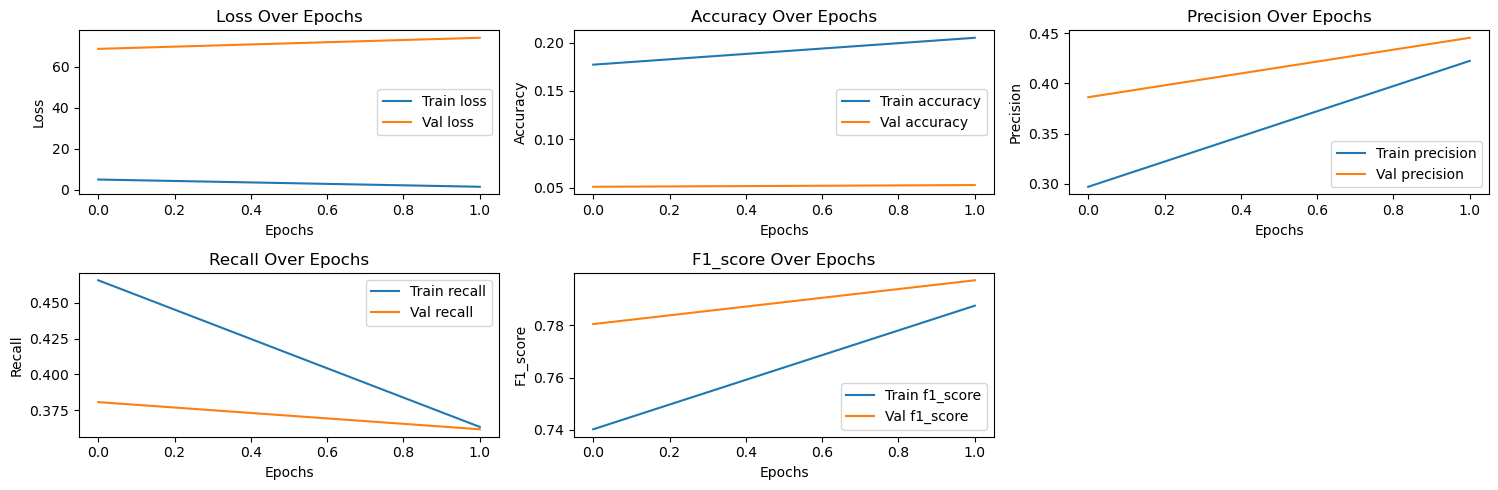

In [87]:
plot_history(sequential_history)

In [89]:
evaluate(X_val_tot, y_val_tot, sequential, output_order)

124/124 [==============================] - 4s 26ms/step
                       precision    recall  f1-score   support

    computer security       0.00      0.00      0.00      1487
             hardware       0.18      0.03      0.06       604
           networking       0.00      0.00      0.00       101
    operating systems       0.03      0.30      0.06       128
                other       0.71      0.45      0.55      2350
             software       0.03      0.00      0.00       515
antivirus and malware       0.00      0.00      0.00         6
     network security       0.63      0.35      0.45       864
             computer       0.10      0.05      0.07       198
  computer components       0.02      0.47      0.05        68
  computer networking       0.16      0.09      0.11      1103
     desktop computer       0.11      0.05      0.07       377
    portable computer       0.13      0.03      0.04       450
              servers       0.08      0.47      0.14       49

# General Classifier

In [15]:
FIX_GENERAL = {
    'computer security': 'computer security',
    'operating systems': 'operating systems',
    'software': 'software',
    'programming languages': 'software',
    'hardware': 'hardware',
    'electronic components': 'hardware',
    'networking': 'networking',
    'internet technology': 'networking'
}

general_tweets = train_tweets.assign(target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_GENERAL,)))
X_train, X_val, y_train, y_val, classes = preprocess_data(general_tweets['text'], general_tweets['target'])
general_net = build_network(X_train, y_train)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              787456    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 2048)              2099200   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                           

In [16]:
general_history = general_net.fit(
    X_train, y_train,
    epochs=EPOCHS,  # Increased number of epochs
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
    ]
).history

Epoch 1/2
1157/1157 [==============================] - 100s 84ms/step - loss: 1.2341 - accuracy: 0.5179 - precision: 0.5541 - recall: 0.4551 - f1_score: 0.7618 - val_loss: 1.0974 - val_accuracy: 0.5320 - val_precision: 0.6250 - val_recall: 0.4803 - val_f1_score: 0.8050 - lr: 0.0010
Epoch 2/2
1157/1157 [==============================] - 91s 79ms/step - loss: 1.0409 - accuracy: 0.5574 - precision: 0.6457 - recall: 0.4864 - f1_score: 0.8171 - val_loss: 1.0177 - val_accuracy: 0.5693 - val_precision: 0.6626 - val_recall: 0.4931 - val_f1_score: 0.8258 - lr: 0.0010


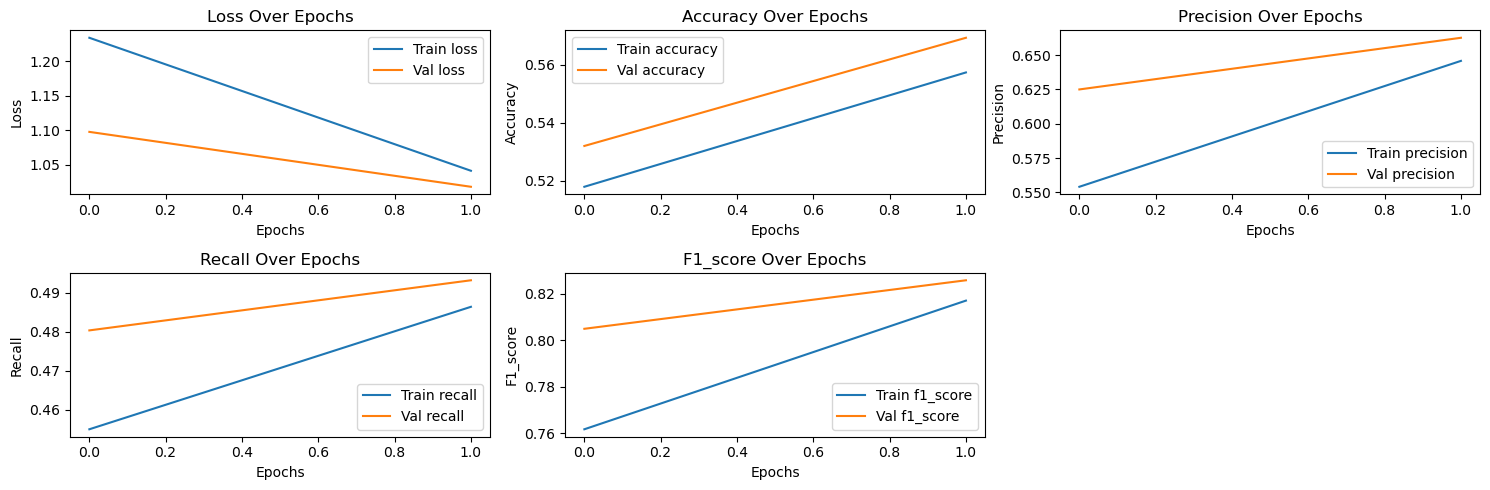

In [17]:
plot_history(general_history)

In [18]:
evaluate(X_val, y_val, general_net, classes)

124/124 [==============================] - 2s 12ms/step
                   precision    recall  f1-score   support

computer security       0.72      0.89      0.80      2319
         hardware       0.64      0.29      0.40       863
       networking       0.65      0.17      0.27       369
operating systems       0.48      0.55      0.51       440
            other       0.66      0.45      0.54       541
         software       0.65      0.67      0.66      1336

        micro avg       0.67      0.64      0.65      5868
        macro avg       0.63      0.50      0.53      5868
     weighted avg       0.66      0.64      0.63      5868
      samples avg       0.66      0.66      0.63      5868

Subset Accuracy: 0.4110
Hamming Loss: 0.1666
AUC Score: 0.6821


# Computer Security Classifier

In [20]:
FIX_CS = {
    'antivirus and malware': 'antivirus and malware',
    'network security': 'network security'
}

cs_tweets = train_tweets.assign(target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_CS,)))

cs_tweets = cs_tweets[
    cs_tweets["watson_list"].apply(lambda x: 'computer security' in x)
].reset_index(drop=True)

X_train, X_val, y_train, y_val, classes = preprocess_data(cs_tweets['text'], cs_tweets['target'])
cs_net = build_network(X_train, y_train)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_10 (Dense)            (None, 1024)              787456    
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                           

In [21]:
cs_history = cs_net.fit(
    X_train, y_train,
    epochs=EPOCHS,  # Increased number of epochs
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )]
).history

Epoch 1/2
677/677 [==============================] - 56s 80ms/step - loss: 1.7415 - accuracy: 0.7309 - precision: 0.7190 - recall: 0.7425 - f1_score: 0.8783 - val_loss: 1.0035 - val_accuracy: 0.7814 - val_precision: 0.7739 - val_recall: 0.7719 - val_f1_score: 0.9046 - lr: 0.0010
Epoch 2/2
677/677 [==============================] - 56s 83ms/step - loss: 1.2653 - accuracy: 0.7516 - precision: 0.7846 - recall: 0.7782 - f1_score: 0.9093 - val_loss: 1.0028 - val_accuracy: 0.8141 - val_precision: 0.7872 - val_recall: 0.7842 - val_f1_score: 0.9135 - lr: 0.0010


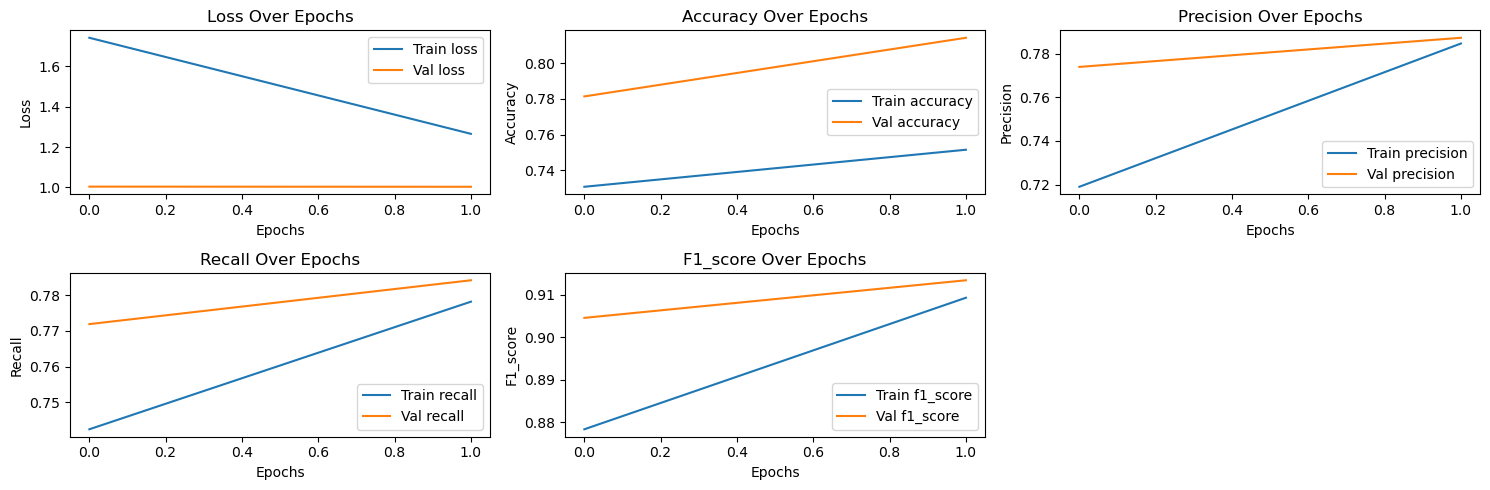

In [22]:
plot_history(cs_history)

In [23]:
evaluate(X_val, y_val, cs_net, classes)

73/73 [==============================] - 1s 18ms/step
                       precision    recall  f1-score   support

antivirus and malware       0.78      0.93      0.85      1471
     network security       0.79      0.84      0.82      1077
                other       0.67      0.31      0.42        26

            micro avg       0.78      0.89      0.83      2574
            macro avg       0.75      0.69      0.70      2574
         weighted avg       0.78      0.89      0.83      2574
          samples avg       0.83      0.90      0.84      2574

Subset Accuracy: 0.6805
Hamming Loss: 0.1324
AUC Score: 0.7384


# Hardware Classifier

In [24]:
FIX_HW = {
    'computer': 'computer',
    'computer components': 'computer components',
    'computer networking': 'computer networking'
}

hw_tweets = train_tweets.assign(target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_HW,)))

hw_tweets = hw_tweets[
    hw_tweets["watson_list"].apply(lambda x: 'hardware' in x)
].reset_index(drop=True)

X_train, X_val, y_train, y_val, classes = preprocess_data(hw_tweets['text'], hw_tweets['target'])
hw_net = build_network(X_train, y_train)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_15 (Dense)            (None, 1024)              787456    
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                           

In [25]:
hw_history = hw_net.fit(
    X_train, y_train,
    epochs=EPOCHS,  # Increased number of epochs
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
    ]
).history

Epoch 1/2
246/246 [==============================] - 30s 111ms/step - loss: 1.6121 - accuracy: 0.6584 - precision: 0.6058 - recall: 0.6363 - f1_score: 0.8165 - val_loss: 1.4100 - val_accuracy: 0.6394 - val_precision: 0.6634 - val_recall: 0.6377 - val_f1_score: 0.8447 - lr: 0.0010
Epoch 2/2
246/246 [==============================] - 20s 81ms/step - loss: 1.2133 - accuracy: 0.7102 - precision: 0.6803 - recall: 0.6344 - f1_score: 0.8542 - val_loss: 0.8900 - val_accuracy: 0.7663 - val_precision: 0.6968 - val_recall: 0.6558 - val_f1_score: 0.8680 - lr: 0.0010


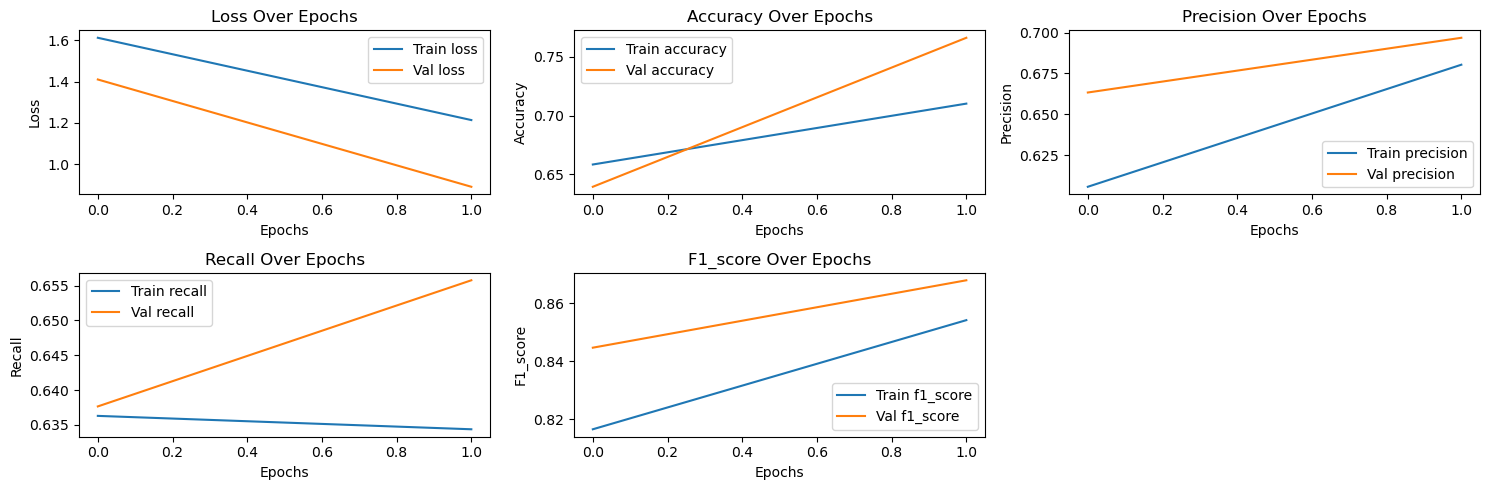

In [26]:
plot_history(hw_history)

In [27]:
evaluate(X_val, y_val, hw_net, classes)

27/27 [==============================] - 1s 15ms/step
                     precision    recall  f1-score   support

           computer       0.73      0.97      0.83       602
computer components       0.64      0.58      0.61       106
computer networking       0.75      0.60      0.66       129
              other       0.74      0.38      0.50        53

          micro avg       0.72      0.83      0.77       890
          macro avg       0.71      0.63      0.65       890
       weighted avg       0.72      0.83      0.76       890
        samples avg       0.76      0.84      0.78       890

Subset Accuracy: 0.6465
Hamming Loss: 0.1278
AUC Score: 0.6928


## Computer Classifier

In [29]:
FIX_COMPUTER = {
    'desktop computer': 'desktop computer',
    'portable computer': 'portable computer',
    'servers': 'servers',
}

computer_tweets = train_tweets.assign(target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_COMPUTER,)))

computer_tweets = computer_tweets[
    computer_tweets["watson_list"].apply(lambda x: 'computer' in x)
].reset_index(drop=True)

X_train, X_val, y_train, y_val, classes = preprocess_data(computer_tweets['text'], computer_tweets['target'])
computer_net = build_network(X_train, y_train)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_20 (Dense)            (None, 1024)              787456    
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_12 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                           

In [30]:
computer_history = computer_net.fit(
    X_train, y_train,
    epochs=EPOCHS,  # Increased number of epochs
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
    ]
).history

Epoch 1/2
176/176 [==============================] - 17s 81ms/step - loss: 2.6533 - accuracy: 0.8326 - precision: 0.6629 - recall: 0.7496 - f1_score: 0.8737 - val_loss: 2.0634 - val_accuracy: 0.8507 - val_precision: 0.7951 - val_recall: 0.8349 - val_f1_score: 0.9371 - lr: 0.0010
Epoch 2/2
176/176 [==============================] - 15s 87ms/step - loss: 2.3191 - accuracy: 0.8583 - precision: 0.8092 - recall: 0.8429 - f1_score: 0.9400 - val_loss: 1.7498 - val_accuracy: 0.8673 - val_precision: 0.8191 - val_recall: 0.8504 - val_f1_score: 0.9447 - lr: 0.0010


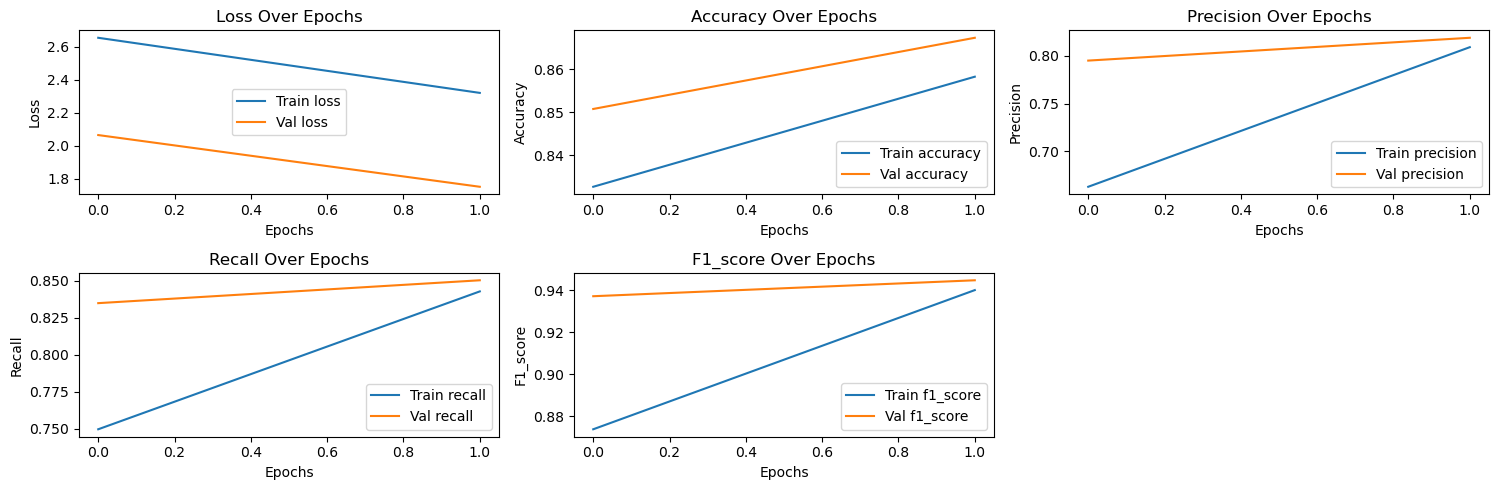

In [31]:
plot_history(computer_history)

In [32]:
evaluate(X_val, y_val, computer_net, classes)

19/19 [==============================] - 1s 34ms/step
                   precision    recall  f1-score   support

 desktop computer       0.25      0.20      0.22         5
            other       0.85      1.00      0.92       513
portable computer       0.25      0.03      0.05        39
          servers       0.89      0.65      0.75        48

        micro avg       0.85      0.90      0.87       605
        macro avg       0.56      0.47      0.48       605
     weighted avg       0.81      0.90      0.84       605
      samples avg       0.87      0.90      0.88       605

Subset Accuracy: 0.8358
Hamming Loss: 0.0659
AUC Score: 0.6067


## Computer Networking Classifier

In [33]:
FIX_COMPUTER_NETWORKING = {
    'router': 'router',
    'wireless technology': 'wireless technology',
}

cn_tweets = train_tweets.assign(
    target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_COMPUTER_NETWORKING,)))

cn_tweets = cn_tweets[
    cn_tweets["watson_list"].apply(lambda x: 'computer networking' in x)
].reset_index(drop=True)

# Train-test split
X_train, X_val, y_train, y_val, classes = preprocess_data(cn_tweets['text'], cn_tweets['target'])
cn_net = build_network(X_train, y_train)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_25 (Dense)            (None, 1024)              787456    
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_15 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                           

In [34]:
cn_history = cn_net.fit(
    X_train, y_train,
    epochs=EPOCHS,  # Increased number of epochs
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
    ]
).history

Epoch 1/2
38/38 [==============================] - 6s 98ms/step - loss: 1.0246 - accuracy: 0.8206 - precision: 0.7055 - recall: 0.7672 - f1_score: 0.7645 - val_loss: 0.8387 - val_accuracy: 0.8760 - val_precision: 0.8116 - val_recall: 0.8538 - val_f1_score: 0.8740 - lr: 0.0010
Epoch 2/2
38/38 [==============================] - 4s 111ms/step - loss: 0.7515 - accuracy: 0.8837 - precision: 0.8262 - recall: 0.8658 - f1_score: 0.8899 - val_loss: 0.6910 - val_accuracy: 0.8760 - val_precision: 0.8376 - val_recall: 0.8682 - val_f1_score: 0.8996 - lr: 0.0010


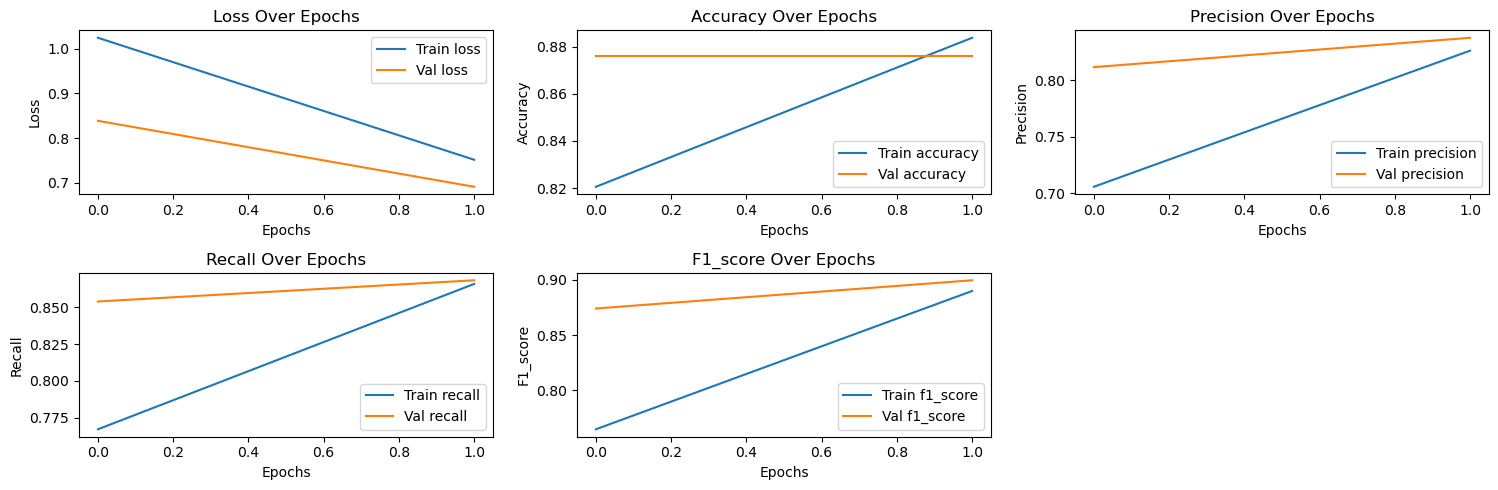

In [35]:
plot_history(cn_history)

In [36]:
evaluate(X_val, y_val, cn_net, classes)

5/5 [==============================] - 0s 14ms/step
                     precision    recall  f1-score   support

             router       0.88      1.00      0.93       113
wireless technology       1.00      0.10      0.18        20

          micro avg       0.88      0.86      0.87       133
          macro avg       0.94      0.55      0.56       133
       weighted avg       0.89      0.86      0.82       133
        samples avg       0.88      0.87      0.87       133

Subset Accuracy: 0.8605
Hamming Loss: 0.1318
AUC Score: 0.5250


# Operating Systems Classifier

In [37]:
FIX_OS = {
    'linux': 'linux',
    'mac os': 'mac os',
    'unix': 'unix',
    'windows': 'windows'
}

os_tweets = train_tweets.assign(target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_OS,)))

os_tweets = os_tweets[
    os_tweets["watson_list"].apply(lambda x: 'operating systems' in x)
].reset_index(drop=True)

# Train-test split
X_train, X_val, y_train, y_val, classes = preprocess_data(os_tweets['text'], os_tweets['target'])
os_net = build_network(X_train, y_train)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_30 (Dense)            (None, 1024)              787456    
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_18 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_19 (Dropout)        (None, 2048)              0         
                                                           

In [38]:
os_history = os_net.fit(
    X_train, y_train,
    epochs=EPOCHS,  # Increased number of epochs
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
    ]
).history

Epoch 1/2
128/128 [==============================] - 15s 100ms/step - loss: 1.2572 - accuracy: 0.5064 - precision: 0.4477 - recall: 0.4029 - f1_score: 0.7180 - val_loss: 1.1764 - val_accuracy: 0.4351 - val_precision: 0.5099 - val_recall: 0.4377 - val_f1_score: 0.7680 - lr: 0.0010
Epoch 2/2
128/128 [==============================] - 14s 112ms/step - loss: 1.0069 - accuracy: 0.6285 - precision: 0.5367 - recall: 0.4665 - f1_score: 0.7868 - val_loss: 0.8426 - val_accuracy: 0.7107 - val_precision: 0.5828 - val_recall: 0.4971 - val_f1_score: 0.8085 - lr: 0.0010


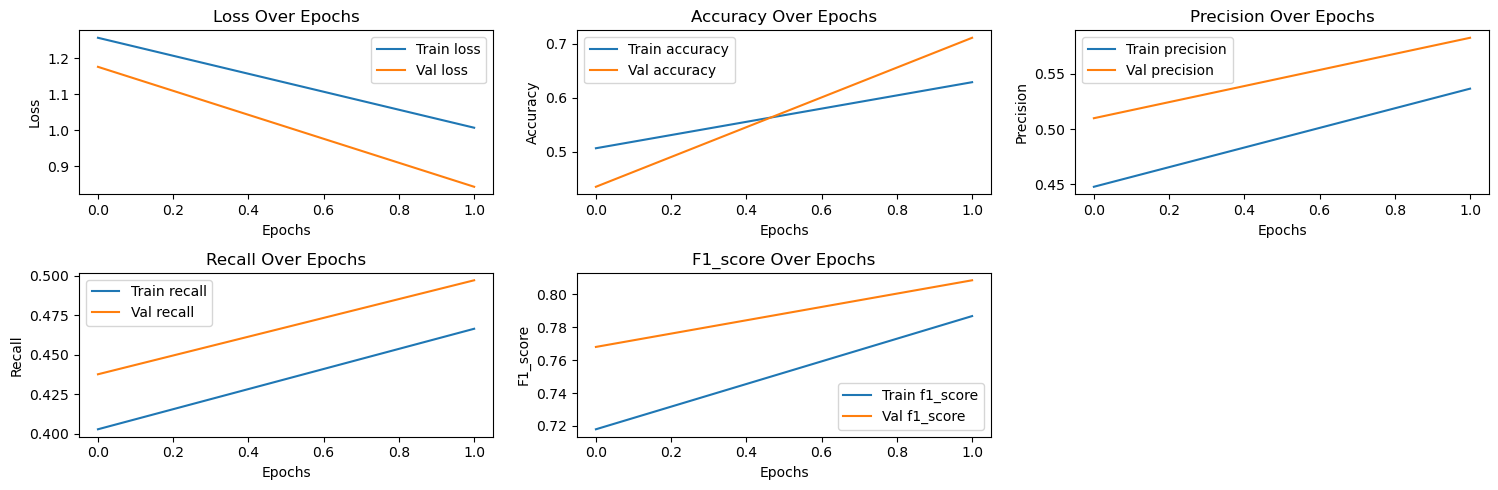

In [39]:
plot_history(os_history)

In [40]:
evaluate(X_val, y_val, os_net, classes)

14/14 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

       linux       0.60      0.91      0.72       184
      mac os       0.81      0.27      0.40        64
       other       0.53      0.91      0.67        53
        unix       0.80      0.54      0.64        82
     windows       0.87      0.77      0.81       111

   micro avg       0.67      0.73      0.70       494
   macro avg       0.72      0.68      0.65       494
weighted avg       0.71      0.73      0.68       494
 samples avg       0.68      0.74      0.69       494

Subset Accuracy: 0.5308
Hamming Loss: 0.1426
AUC Score: 0.7760


# Software Classifier

In [42]:
FIX_SW = {
    'databases': 'databases',
}

sw_tweets = train_tweets.assign(target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_SW,)))

sw_tweets = sw_tweets[
    sw_tweets["watson_list"].apply(lambda x: 'software' in x)
].reset_index(drop=True)

# Train-test split
X_train, X_val, y_train, y_val, classes = preprocess_data(sw_tweets['text'], sw_tweets['target'])
sw_net = build_network(X_train, y_train)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_35 (Dense)            (None, 1024)              787456    
                                                                 
 dropout_21 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_21 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_22 (Dropout)        (None, 2048)              0         
                                                           

In [43]:
sw_history = sw_net.fit(
    X_train, y_train,
    epochs=EPOCHS,  # Increased number of epochs
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
    ]
).history

Epoch 1/2
358/358 [==============================] - 31s 81ms/step - loss: 0.6895 - accuracy: 0.7144 - precision: 0.6667 - recall: 0.6568 - f1_score: 0.7330 - val_loss: 0.5616 - val_accuracy: 0.7400 - val_precision: 0.7114 - val_recall: 0.7010 - val_f1_score: 0.7779 - lr: 0.0010
Epoch 2/2
358/358 [==============================] - 30s 84ms/step - loss: 0.4934 - accuracy: 0.7871 - precision: 0.7320 - recall: 0.7198 - f1_score: 0.7991 - val_loss: 0.4404 - val_accuracy: 0.8443 - val_precision: 0.7507 - val_recall: 0.7422 - val_f1_score: 0.8233 - lr: 0.0010


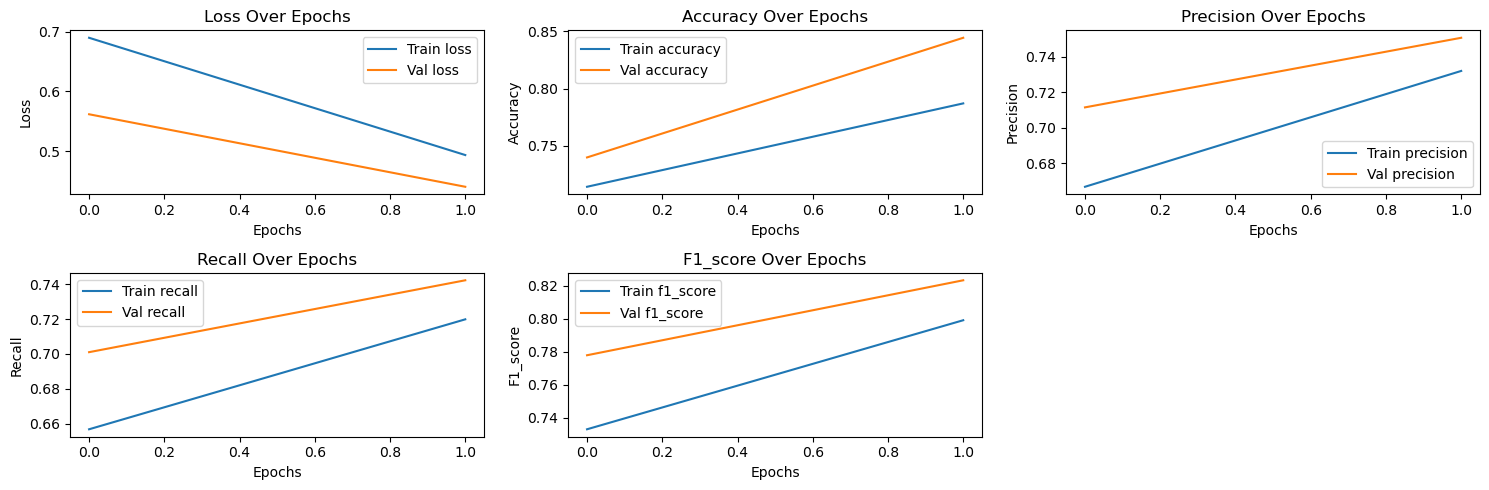

In [44]:
plot_history(sw_history)

In [45]:
evaluate(X_val, y_val, sw_net, classes)

39/39 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

   databases       0.76      0.84      0.80       486
       other       0.81      0.93      0.87       741

   micro avg       0.79      0.89      0.84      1227
   macro avg       0.79      0.88      0.83      1227
weighted avg       0.79      0.89      0.84      1227
 samples avg       0.83      0.89      0.85      1227

Subset Accuracy: 0.7653
Hamming Loss: 0.1711
AUC Score: 0.8153


# Testing

In [48]:
class ClassifierSystem:
    def __init__(self, models: dict[str, (BaseEstimator, list[str])], embedder_path: str, embedding_dim: Any):
        self.models = models
        self.embedder_path = embedder_path
        self.embedding_dim = embedding_dim

    def predict(self, x):
        x_emb = self.preprocess_texts(list_str=x)
        filter_predict = self.models['filter']['model'].predict(x_emb)

        translate = lambda predictions, classes: [[
            classes[yi] for yi in y_hat
        ] for y_hat in [
            np.where(y_hat == 1)[0]
            for y_hat in predictions
        ]]

        general_predict = translate(
            predictions=self.models['general_classifier']['model'].predict(x_emb),
            classes=self.models['general_classifier']['classes']
        )
        y_prediction = general_predict.copy()

        for idx, yp in enumerate(general_predict):
            y_prediction_i = set(yp)
            if 'computer security' in y_prediction_i:
                y_prediction_i = set(translate(
                    predictions=self.models['computer_security_classifier']['model'].predict(x_emb),
                    classes=self.models['computer_security_classifier']['classes']
                )[0]) - {'other'} | set(y_prediction_i)
            if 'operating systems' in y_prediction_i:
                y_prediction_i = set(translate(
                    predictions=self.models['operating_systems_classifier']['model'].predict(x_emb),
                    classes=self.models['operating_systems_classifier']['classes']
                )[0]) - {'other'} | set(y_prediction_i)
            if 'software' in y_prediction_i:
                y_prediction_i = set(translate(
                    predictions=self.models['software_classifier']['model'].predict(x_emb),
                    classes=self.models['software_classifier']['classes']
                )[0]) - {'other'} | set(y_prediction_i)
            if 'hardware' in y_prediction_i:
                y_prediction_i = set(translate(
                    predictions=self.models['hardware_classifier']['model'].predict(x_emb),
                    classes=self.models['hardware_classifier']['classes']
                )[0]) - {'other'} | set(y_prediction_i)
            if 'computer' in y_prediction_i:
                y_prediction_i = set(translate(
                    predictions=self.models['computer_classifier']['model'].predict(x_emb),
                    classes=self.models['computer_classifier']['classes']
                )[0]) - {'other'} | set(y_prediction_i)
            if 'computer networking' in y_prediction_i:
                y_prediction_i = set(translate(
                    predictions=self.models['computer_networking_classifier']['model'].predict(x_emb),
                    classes=self.models['computer_networking_classifier']['classes']
                )[0]) - {'other'} | set(y_prediction_i)

            y_prediction[idx] = list(y_prediction_i)

        for idx in range(len(filter_predict)):
            if not filter_predict[idx]:
                y_prediction[idx] = ['other']
        return y_prediction

    def load_embedder_dict(self) -> dict[Union[str, list[str]], np.ndarray[Any, np.dtype]]:
        embeddings_dict = {}
        f = open(self.embedder_path, 'r', encoding='utf-8')

        for line in f:
            values = line.split()
            word = values[:-self.embedding_dim]

            if type(word) is list:
                word = ' '.join(word)

            vector = np.asarray([float(val) for val in values[-self.embedding_dim:]])
            embeddings_dict[word] = vector

        f.close()

        return embeddings_dict

    def preprocess_texts(self, list_str: pd.Series) -> np.ndarray[Any, np.dtype]:
        if self.embedding_dim is None:
            return tokenizer_transform(
                x=list_str,
                embedder_addr=self.embedder_path,
                preprocessing_list=[replace_text_components, clean_text]
            )

        embedder = self.load_embedder_dict()
        list_embedded_str = np.zeros((len(list_str), self.embedding_dim))

        for i, text in enumerate(list_str):
            tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)

            for token in tokens:
                try:
                    list_embedded_str[i] += embedder[token.lower()]
                except KeyError:
                    continue

        return list_embedded_str

In [49]:
models_dict = {
    'filter': {
        'model': joblib.load(filename='models/filter.pkl'),
        'classes': ['not relevant', 'relevant']
    },
    'general_classifier': {
        'model': general_net,
        'classes': ['computer security', 'hardware', 'networking', 'operating systems', 'other', 'software'],
    },
    'computer_security_classifier': {
        'model': cs_net,
        'classes': ['antivirus and malware', 'network security', 'other']
    },
    'operating_systems_classifier': {
        'model': os_net,
        'classes': ['linux', 'mac os', 'other', 'unix', 'windows']
    },
    'software_classifier': {
        'model': sw_net,
        'classes': ['databases', 'other']
    },
    'hardware_classifier': {
        'model': hw_net,
        'classes': ['computer', 'computer components', 'computer networking', 'other']
    },
    'computer_classifier': {
        'model': computer_net,
        'classes': ['desktop computer', 'other', 'portable computer', 'servers']
    },
    'computer_networking_classifier': {
        'model': cn_net,
        'classes': ['router', 'wireless technology']
    }
}

In [50]:
system = ClassifierSystem(
    models=models_dict,
    embedder_path='basel/ATTACK-BERT',
    embedding_dim=None
)

In [ ]:
X_train, X_val, y_train, y_val, classes = preprocess_data(train_tweets['text'], train_tweets['target'])

In [292]:
with open('data/tweets-dataset/testing_tweets_for_category_clf.pkl', 'rb') as f:
    test_tweets = pd.DataFrame(data=pickle.load(file=f), columns=[
        '_id', 'date',
        'id', 'relevant', 'text', 'tweet', 'type', 'watson',
        'annotation', 'urls', 'destination_url',
        'valid_certificate', 'watson_list', 'target'
    ])

test_tweets = test_tweets.assign(target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_GENERAL,)))
test_tweets['text'] = [replace_text_components(t) for t in test_tweets['text']]
test_tweets['text'] = [clean_text(t) for t in test_tweets['text']]
test_tweets['text'] = [lemmatize_text(t) for t in test_tweets['text']]
test_tweets['text'] = [remove_stopwords(t) for t in test_tweets['text']]

#X_test = embedder.transform(test_tweets['text']).toarray()
X_test = embedder.encode(list(test_tweets['text']))
y_test = mlb.transform(list(test_tweets['target']))

In [293]:
# Predictions
y_pred = sequential.predict(X_test)
y_pred_binary = (y_pred > 0.4).astype(int)

# Evaluation using Multi-label metrics
hamming = hamming_loss(y_test, y_pred_binary)
subset_accuracy = accuracy_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_binary)

print(classification_report(y_test, y_pred_binary, target_names=mlb.classes_, zero_division=0))
print(f"Subset Accuracy: {subset_accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"AUC Score: {roc_auc:.4f}")

100/100 [==============================] - 1s 8ms/step
                   precision    recall  f1-score   support

computer security       0.81      0.88      0.85      1875
         hardware       0.73      0.64      0.68       649
       networking       0.70      0.60      0.65       282
operating systems       0.80      0.74      0.77       280
            other       0.68      0.70      0.69       451
         software       0.74      0.75      0.75      1072

        micro avg       0.77      0.77      0.77      4609
        macro avg       0.74      0.72      0.73      4609
     weighted avg       0.76      0.77      0.77      4609
      samples avg       0.77      0.78      0.75      4609

Subset Accuracy: 0.5792
Hamming Loss: 0.1113
AUC Score: 0.8106


### Key Steps in the Code:

1. **Multi-label Binarization**:
   We use `MultiLabelBinarizer` to transform the hierarchical labels into a binary matrix, where each column corresponds to a category.
2. **Feature Extraction**:
   `TfidfVectorizer` is used to convert text into numerical features. You can replace this with other methods such as Word2Vec or BERT embeddings if needed.
3. **Neural Network**:
   The model architecture uses dense layers, dropout for regularization, and a final sigmoid activation to handle multi-label classification.
4. **Evaluation**:
   After training, the model is evaluated using `accuracy_score` and `hamming_loss`. You can extend this to compute hierarchical metrics like **hierarchical F1** by considering label relationships.

### Hierarchical Classification:
To specifically account for hierarchical relationships, you may need to modify the loss function or use a model designed for hierarchical classification. Some approaches involve **Label Powerset** or a **tree-structured output** to make predictions at each level of the hierarchy.

#### Advanced Considerations:
- **Hierarchical Loss Functions**: Define a custom loss that considers the hierarchy, such as penalizing incorrect predictions at higher levels more than at lower levels.
- **Tree-Structured Neural Networks**: For more complex cases, a tree-structured neural network can be used to predict categories in a bottom-up or top-down manner.

This is a basic architecture. You can enhance it by introducing more sophisticated techniques like **Graph Neural Networks** for hierarchical relationships or other ensemble methods.